This notebook does all the initial fitting with ROHSA. Lots of testing with multiple components so it's a little messy. But, here, we conduct the chi2 test as well as the noise analysis to determine that 3 gaussians are best. Midway through the notebook, we saved the fits files. DO NOT run these cells again, there's no need to. They should be well marked. We also reconstructed the data cube in this notebook. It ends with some moment map stuff that isn't particularly insightful.

In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from ROHSApy import ROHSA
import astropy
import astropy.units as u
import astropy.constants as c
from astropy import wcs
from spectral_cube import SpectralCube
from importlib import reload
from photutils import find_peaks
import r_mod
import matplotlib.gridspec as gridspec
import time
from fractions import Fraction
import os
import column_density as cd
from scipy.optimize import curve_fit
from scipy import ndimage, misc
from astropy.nddata.utils import Cutout2D
from astropy.coordinates import SkyCoord
import pandas as pd

In [2]:
r_mod = reload(r_mod)
cd = reload(cd)

In [4]:
ra1, ra2, dec1, dec2 = 35, 85, 135, 185
s1, s2 = 170, 250

hdul = fits.open('/Users/simonsmith/Documents/SURP/Data/HC2_HC5N_all_rebase3_trim.fits')
head = hdul[0].header
data = hdul[0].data[s1:s2, dec1:dec2, ra1:ra2]
cube = SpectralCube.read(hdul)

cube3 = cube.with_spectral_unit(u.m/u.s, velocity_convention='radio', rest_value=head['RESTFRQ'] * u.Hz)[s1:s2] 
rad_v = cube3.spectral_axis

test_cube = cube3.unmasked_data[:, dec1:dec2, ra1:ra2]
test_head = cube3.header


x_pix, y_pix, z_pix = head['NAXIS1'], head['NAXIS2'], head['NAXIS3']
x_deg, y_deg = x_pix*head['CDELT1']*u.deg, y_pix*head['CDELT2']*u.deg

x_pc, y_pc = (x_deg.to(u.rad)*140*u.pc)/u.rad, (y_deg.to(u.rad)*140*u.pc)/u.rad
x_au, y_au = x_pc.to(u.au), y_pc.to(u.au)

pix_scale_pc = np.abs(x_pc/x_pix)
pix_scale_au = np.abs(y_au/y_pix)


hdul2 = fits.open('/Users/simonsmith/Documents/SURP/Data/HC2_HC5N_all_rebase3_mom0_QA_trim.fits')
coord_head = hdul2[0].header

ls_tmc1 = Cutout2D(hdul2[0].data, position=(60, 165), size=(70, 60), wcs=wcs.WCS(coord_head))



In [5]:
c1ra1, c1ra2, c1dec1, c1dec2 = 30, 90, 130, 200
c2ra1, c2ra2, c2dec1, c2dec2 = 70, 115, 190, 235


cube3 = cube.with_spectral_unit(u.m/u.s, velocity_convention='radio', rest_value=head['RESTFRQ'] * u.Hz)[170:250] 
rad_v = cube3.spectral_axis
ls_cube = cube3[:, c1dec1:c1dec2, c1ra1:c1ra2]
ls_data = ls_cube.unmasked_data[:, :, :]
ls_head = ls_cube.header

ls_head['NAXIS2']*pix_scale_pc

<Quantity 0.41803561 pc>

In [6]:
ls_head

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    3                                                  
NAXIS1  =                   60                                                  
NAXIS2  =                   70                                                  
NAXIS3  =                   80                                                  
BUNIT   = '' / Tmb                                                              
INSTRUME= 'KFPA    '                                                            
BMAJ    = 0.008458002825349066                                                  
BMIN    = 0.008458002825349066                                                  
BPA     =                  0.0                                                  
TELESCOP= 'GBT     '                                                            
BEAM    = 'Beam: BMAJ=30.448

In [7]:
tester = cube3[0:1, c1dec1:c1dec2, c1ra1:c1ra2].header

In [8]:
r_mod.fill_nan(ls_data)

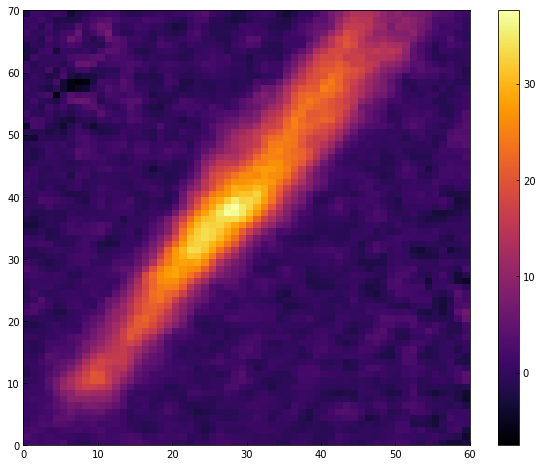

In [9]:
plt.figure(figsize=(10,8))
plt.pcolormesh(np.sum(ls_data[30:50], 0), cmap='inferno')
plt.colorbar()
plt.show()

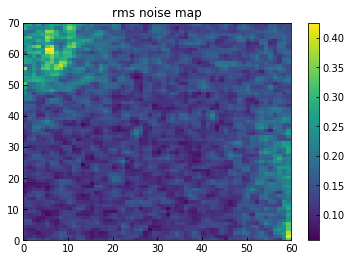

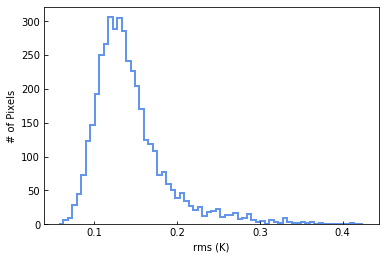

In [10]:
plt.pcolormesh(np.std(ls_data[:20, :, :], 0))
plt.colorbar()
np.std(ls_data[:20, :, :])
plt.title('rms noise map')
plt.show()

plt.figure(figsize=(6, 4))
plt.hist(np.array(np.ravel(np.std(ls_data[:20, :, :], 0))), 
         bins='auto', histtype='step', linewidth=2, color='cornflowerblue')
plt.ylabel('# of Pixels')
plt.xlabel('rms (K)')
plt.xticks([0.1, 0.2, 0.3, 0.4])
plt.savefig('rms_noise.png')

In [78]:
tmc1_hdu = fits.open('tmc1_ls.fits')

In [79]:
tmc1_hdu[1].header = tmc1_hdu[2].header

In [80]:
tmc1_hdu[1].header

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   60                                                  
NAXIS2  =                   70                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
EXTNAME = 'INTENSITIES G2'     / extension name                                 

In [82]:
filename = "HC2_HC5N_CubeEx.dat" #@param
fileout = "HC2_HC5N_CubeEx_gauss_run_0.dat" #@param
filename_noise = ''
n_gauss = 3        #@param {type:"slider", min:1, max:12, step:1}                                                                                                                                                                                                                             
lambda_amp = 100 #@param {type:"slider", min:0, max:1000, step:1}
lambda_mu = 100       #@param {type:"slider", min:0, max:1000, step:1}
lambda_sig = 100      #@param {type:"slider", min:0, max:1000, step:1}
lambda_var_amp = 0.                                                                                                                                                                                                                                                           
lambda_var_mu = 0.                                                                                                                                                                                                                                                        
lambda_var_sig = 0.   #@param {type:"slider", min:0, max:10000, step:1}                                                                                                                                                                                                                                                            
amp_fact_init = 0.66  # times max amplitude of additional Gaussian                                                                                                                                                                                                                                                          
sig_init = 4.         # dispersion of additional Gaussian                                                                                                                                                                                                                                                                   
init_option = 'mean'  # init ROHSA with the mean or the std spectrum                                                                                                                                                                                                                                                      
maxiter_init = 15000  # max iteration for L-BFGS-B alogorithm init mean                                                                                                                                                                                                                                        
maxiter = 400         #@param {type:"slider", min:1, max:800, step:1}                                                                                                                                                                                                                                                         
m = 10                # number of corrections used in the limited memory matrix                                                                                                                                                                                                                               
noise = ".false."     # if false - STD map computed by ROHSA with lstd and ustd                                                                                                                                                                                                           
regul = ".true."      # if true - activate regulation                                                                                                                                                                                                                                                                 
descent = ".true."    #@param [".true.", ".false."]                                                                                                                                                                                                                       
lstd = 1              #@param {type:"slider", min:1, max:400, step:1}                                                                                                                                                                                                                
ustd = 20             #@param {type:"slider", min:1, max:400, step:1}                                                                                                                                                                                                                 
iprint = -1           #@param ["-1", "0", "1"]                                                                                                                                                                                                                                                                                      
iprint_init = -1      # print option init                                              
save_grid = ".false." #@param [".true.", ".false."] 

core = ROHSA(ls_data, hdr = ls_head)            
core.cube2dat(filename=filename)
core.gen_parameters(filename=filename, 
                    fileout=fileout,  
                    n_gauss=n_gauss,
                    lambda_amp=lambda_amp,
                    lambda_mu=lambda_mu,
                    lambda_sig=lambda_sig,
                    lambda_var_sig=lambda_var_sig,
                    maxiter=maxiter,
                    descent=descent,
                    lstd=lstd,
                    ustd=ustd,
                    iprint=iprint,
                    save_grid=save_grid)

Generate HC2_HC5N_CubeEx.dat file readable by fortran
Generate parameters.txt file


In [83]:
! nohup ./ROHSA/src/ROHSA parameters.txt

appending output to nohup.out


In [84]:
gaussian = core.read_gaussian("HC2_HC5N_CubeEx_gauss_run_0.dat")
params = core.physical_gaussian(gaussian)
print("dim cube = " + str(gaussian.shape))

model = core.return_result_cube(gaussian=gaussian)

reconstructed_cube = core.return_result_cube(gaussian)

amplitude = params[0::3]
position = params[1::3]
dispersion = -1*params[2::3]

integral = amplitude * dispersion



Opening data file
dim cube = (9, 70, 60)


In [57]:
np.mean(amplitude[0])

0.6204741240610576

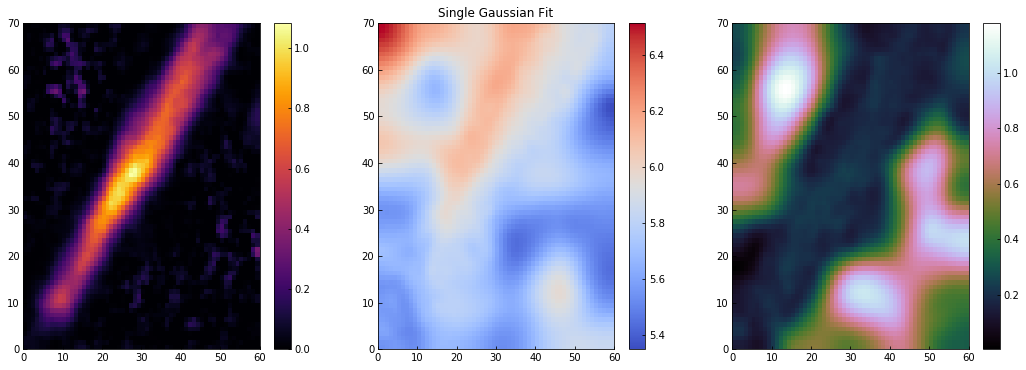

In [83]:
fig = plt.figure(figsize=(18, 6))

ax1 = fig.add_subplot(131)
im1 = ax1.pcolormesh(integral[0], cmap='inferno')
plt.colorbar(im1)

ax2 = fig.add_subplot(132)
im2 = ax2.pcolormesh(position[0], cmap='coolwarm')
plt.colorbar(im2)
ax2.set_title('Single Gaussian Fit')

ax3 = fig.add_subplot(133)
im3 = ax3.pcolormesh(dispersion[0], cmap='cubehelix')
plt.colorbar(im3)

plt.show()

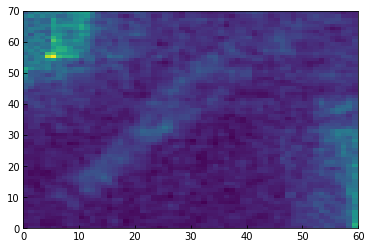

In [65]:
plt.pcolormesh(np.std(ls_data-reconstructed_cube, 0))

0

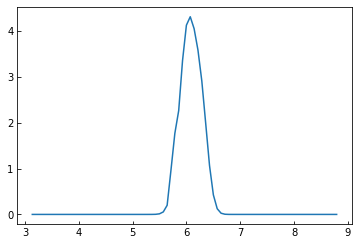

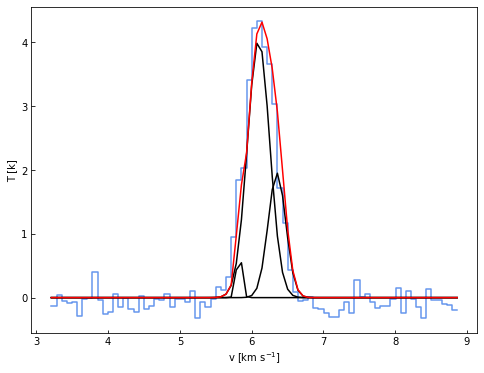

In [146]:
y, x = 40, 30
vel_range = np.array(rad_v/1000)
plt.plot(vel_range, model[:, y, x][::-1])
core.plot_spect(gaussian, idy=y, idx=x)

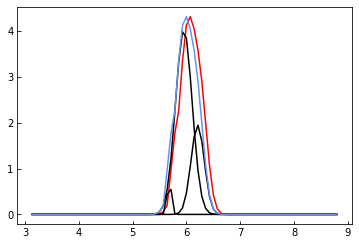

In [147]:
a, b, c = amplitude[0][y, x], position[0][y, x], -dispersion[0][y, x]
temp_spec1 = a*np.exp(-((vel_range-b)**2/(2.*c**2)))

a, b, c = amplitude[1][y, x], position[1][y, x], -dispersion[1][y, x]
temp_spec2 = a*np.exp(-((vel_range-b)**2/(2.*c**2)))

a, b, c = amplitude[2][y, x], position[2][y, x], -dispersion[2][y, x]
temp_spec3 = a*np.exp(-((vel_range-b)**2/(2.*c**2)))

plt.plot(vel_range, model[:, y, x][::-1], color='r')
plt.plot(vel_range, temp_spec1[::-1], color='k')
plt.plot(vel_range, temp_spec2[::-1], color='k')
plt.plot(vel_range, temp_spec3[::-1], color='k')
plt.plot(vel_range, (temp_spec1+temp_spec2+temp_spec3)[::-1], color='cornflowerblue')

In [97]:
def mean2vel(CRVAL, CDELT, CRPIX, mean):
    return [(CRVAL + CDELT * (mean[i] - CRPIX)) for i in range(len(mean))]

x_range = np.arange(80)
vel = mean2vel(ls_head["CRVAL3"]*1.e-3, ls_head["CDELT3"]*1.e-3, ls_head["CRPIX3"], x_range)

In [98]:
aall, ball, call = amplitude[0], position[0], -dispersion[0]
temp_cube1 = np.array([aall*np.exp(-((v-ball)**2/(2.*call**2))) for v in vel])
aall, ball, call = amplitude[1], position[1], -dispersion[1]
temp_cube2 = np.array([aall*np.exp(-((v-ball)**2/(2.*call**2))) for v in vel])
aall, ball, call = amplitude[2], position[2], -dispersion[2]
temp_cube3 = np.array([aall*np.exp(-((v-ball)**2/(2.*call**2))) for v in vel])

rebuilt_cube = temp_cube3+temp_cube2+temp_cube1

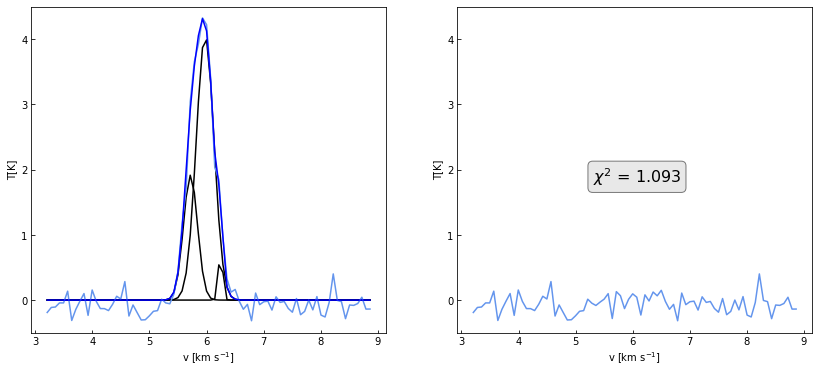

In [196]:
x = 30
y = 40
fig = plt.figure(figsize=(14, 6))

ax1 = fig.add_subplot(121)


ax1.plot(vel, temp_cube1[:, y, x], color='k')
ax1.plot(vel, temp_cube2[:, y, x], color='k')
ax1.plot(vel, temp_cube3[:, y, x], color='k')
ax1.plot(vel, ls_data[:, y, x], color='cornflowerblue')
ax1.plot(vel, rebuilt_cube[:, y, x], color='b')
#ax1.plot(vel, ls_data[:, y, x], color='cornflowerblue')

#ax1.plot(vel, model[:, y, x]-rebuilt_cube[:, y, x])

ax1.set_ylabel('T[K]')
ax1.set_xlabel('v [km s$^{-1}$]')
ax1.set_ylim(-0.5, 4.5)

ax2 = fig.add_subplot(122)

ax2.plot(vel, ls_data[:, y, x]-rebuilt_cube[:, y, x], color='cornflowerblue')
#ax2.plot(vel, rebuilt_cube[:, y, x], color='k', alpha=0.5)
#ax2.plot(vel, ls_data[:, y, x], color='cornflowerblue')

resid = ls_data[:, y, x]-rebuilt_cube[:, y, x]
params = (55-25) - 3*3
std = np.std(ls_data[:20, y, x])
chi2 = np.sum(resid[25:55]**2) / std**2 / (params)

textstr = "$\chi^2$ = "+str(np.round(chi2, 3))
props = dict(boxstyle='round', facecolor='lightgrey', alpha=0.5)
ax2.text(5.3, 1.8, textstr, bbox=props, fontsize=16)

ax2.set_ylim(-0.5, 4.5)
ax2.set_ylabel('T[K]')
ax2.set_xlabel('v [km s$^{-1}$]')

plt.show()

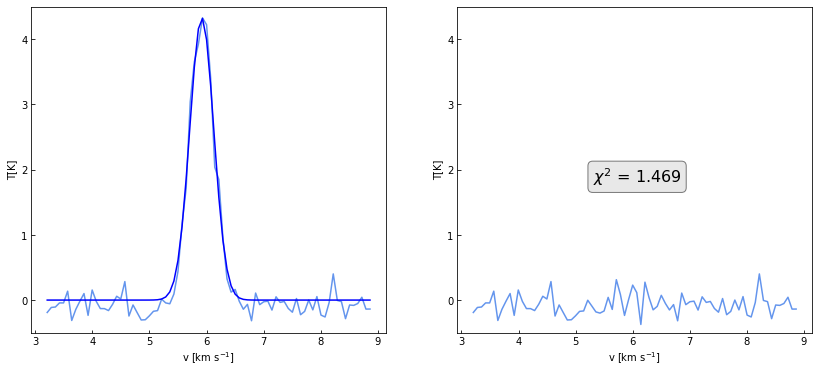

In [192]:
x = 30
y = 40
fig = plt.figure(figsize=(14, 6))

ax1 = fig.add_subplot(121)

ax1.plot(vel, ls_data[:, y, x], color='cornflowerblue')
ax1.plot(vel, model[:, y, x], color='b')

ax1.set_ylabel('T[K]')
ax1.set_xlabel('v [km s$^{-1}$]')
ax1.set_ylim(-0.5, 4.5)

ax2 = fig.add_subplot(122)

ax2.plot(vel, ls_data[:, y, x]-model[:, y, x], color='cornflowerblue')

resid = ls_data[:, y, x]-model[:, y, x]
params = (55-25) - 3
std = np.std(ls_data[:20, y, x])
chi2 = np.sum(resid[25:55]**2) / std**2 / (params)

textstr = "$\chi^2$ = "+str(np.round(chi2, 3))
props = dict(boxstyle='round', facecolor='lightgrey', alpha=0.5)
ax2.text(5.3, 1.8, textstr, bbox=props, fontsize=16)

ax2.set_ylim(-0.5, 4.5)
ax2.set_ylabel('T[K]')
ax2.set_xlabel('v [km s$^{-1}$]')

plt.show()

### Akaike Information Criterion

g2_model, g3_model, g4_model

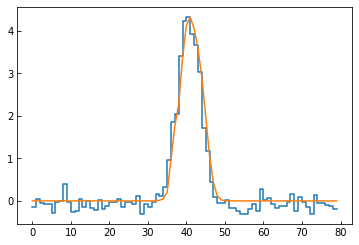

In [61]:
plt.step(range(0, 80), ls_data[:, 40, 30])
plt.plot(model[:, 40, 30])

In [65]:
test_obs = ls_data[40][30]
test_exp2 = g2_model[40][30]
test_exp3 = g3_model[40][30]
test_exp4 = g4_model[40][30]

In [66]:
chi2_2 = (test_obs - test_exp2)**2/test_exp2
aic_2 = np.sum(chi2_2[10:30]) + 2*6 + (2*6*7)/(20-6-1)

chi2_3 = (test_obs - test_exp3)**2/test_exp3
aic_3 = np.sum(chi2_3[10:30]) + 2*9 + (2*9*10)/(20-9-1)

chi2_4 = (test_obs - test_exp4)**2/test_exp4
aic_4 = np.sum(chi2_4[10:30]) + 2*12 + (2*12*13)/(20-12-1)

/Users/simonsmith/anaconda3/lib/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


In [68]:
np.exp(aic_4-aic_3)

<Quantity 1.43567604e+14>

### Residuals

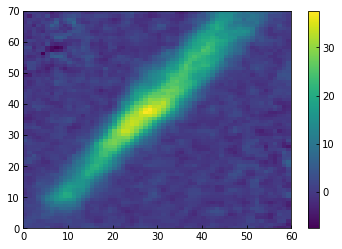

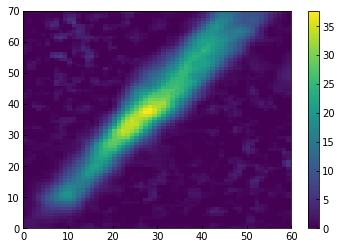

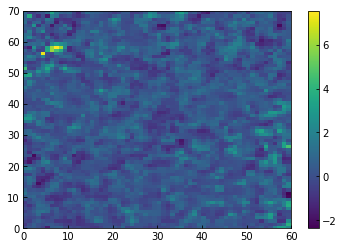

In [66]:
plt.pcolormesh(np.sum(ls_data[30:50], axis=0))
plt.colorbar()
plt.show()
plt.pcolormesh(np.sum(model[30:50], axis=0))
plt.colorbar()
plt.show()

plt.pcolormesh(np.sum(model[30:50]-ls_data[30:50], axis=0))
plt.colorbar()
plt.show()

In [21]:
mod_sum = np.sum(model, axis=0)
mod_mask = mod_sum > 20*np.std(model)
mod_cover = np.empty(mod_mask.shape)
mod_cover.fill(np.nan)
mod_cover[mod_mask == True] = 1

'''
for i in range(45, 59):
    for j in range(15, 30):
        mod_cover[j][i] = np.nan
        mod_mask[j][i] = 0
for i in range(0, 20):
    for j in range(50, 69):
        mod_cover[j][i] = np.nan
        mod_mask[j][i] = 0
'''

'\nfor i in range(45, 59):\n    for j in range(15, 30):\n        mod_cover[j][i] = np.nan\n        mod_mask[j][i] = 0\nfor i in range(0, 20):\n    for j in range(50, 69):\n        mod_cover[j][i] = np.nan\n        mod_mask[j][i] = 0\n'

In [19]:
mod_mask[10][4]

True

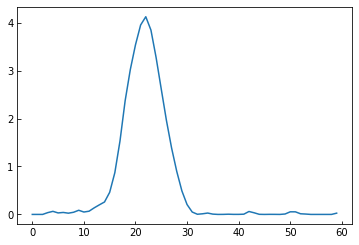

In [83]:
plt.plot(model[40][30])

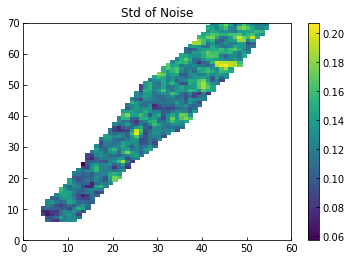

In [15]:
resid = model - ls_data

plt.pcolormesh(mod_cover*np.std(resid[:20, :, :], axis=0))
plt.title('Std of Noise')
plt.colorbar()
plt.show()
'''
plt.pcolormesh(mod_cover*np.std(resid[30:50, :, :], axis=0))
plt.colorbar()
plt.contour(mod_mask, colors='white')
plt.title('Std of Resid')
'''
plt.show()

Text(0.5,1,'Histogram of pixel stds for 6C')

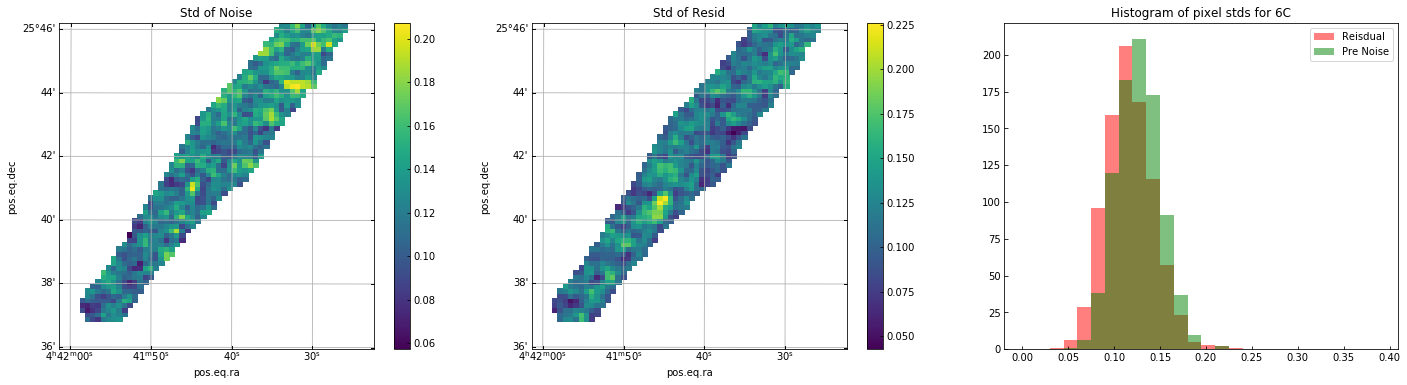

In [82]:
resid = ls_data - model

pre_stds = (np.ravel(mod_mask*np.std(resid[10:30, :, :], axis=0)))
pre_stds = pre_stds[pre_stds>0]
new_pre_stds = []
for i in pre_stds:
    new_pre_stds.append(float(i))
    
pos_stds = (np.ravel(mod_mask*np.std(resid[50:70, :, :], axis=0)))
pos_stds = pos_stds[pos_stds>0]
new_pos_stds = []
for i in pos_stds:
    new_pos_stds.append(float(i))



ls_stds = (np.ravel(mod_mask*np.std(resid[30:50, :, :], axis=0)))
ls_stds = ls_stds[ls_stds>0]
new_ls_stds = []
for i in ls_stds:
    new_ls_stds.append(float(i))
    
bins = np.arange(0, 0.4, 0.015)



fig = plt.figure(figsize=[24, 6], constrained_layout=False)
ax1 = fig.add_subplot(131, projection=ls_tmc1.wcs)
im1 = ax1.pcolormesh(mod_cover*np.std(resid[:20, :, :], axis=0))
ax1.set_title('Std of Noise')
cbar1 = plt.colorbar(im1)

ax2 = fig.add_subplot(132, projection=ls_tmc1.wcs)
im2 = ax2.pcolormesh(mod_cover*np.std(resid[30:50, :, :], axis=0))
ax2.set_title('Std of Resid')
cbar2 = plt.colorbar(im2)

ax3 = fig.add_subplot(133)
ax3.hist(new_ls_stds, color='red', alpha = 0.5, label='Reisdual', bins=bins)
ax3.hist(new_pre_stds, color='green', alpha = 0.5, label='Pre Noise', bins=bins) 
#ax3.hist(new_pos_stds, color='blue', alpha = 0.5, label='Pps Noise', bins=bins)
ax3.legend()
ax3.set_title('Histogram of pixel stds for 6C')



#plt.savefig('6fiber_fit.png')

In [165]:
d = {'# of Components':6, 
      'Mean of Res':np.mean(new_ls_stds), 
      'Mean of Noise':np.mean(new_pre_stds), 
      'Std of Res':np.std(new_ls_stds), 
      'Std of Noise':np.std(new_pre_stds)}
#d = [[1, np.mean(new_ls_stds), np.mean(new_pre_stds), np.std(new_ls_stds), np.std(new_pre_stds)]]

In [166]:
#df = pd.DataFrame(data=d, columns=['# of Components', 'Mean of Res', 'Mean of Noise', 'Std of Res', 'Std of Noise'])
df = df.append(d, ignore_index=True)

In [167]:
print(df)

   # of Components  Mean of Res  Mean of Noise  Std of Res  Std of Noise
0              1.0     0.213566       0.126724    0.059506      0.023835
1              2.0     0.160757       0.126727    0.047204      0.023837
2              3.0     0.116020       0.126729    0.025644      0.023838
3              4.0     0.107697       0.126728    0.023846      0.023838
4              5.0     0.115412       0.126715    0.027392      0.023850
5              6.0     0.118500       0.126723    0.029090      0.023842


In [168]:
df.to_csv('noise_comp.csv')

It has become clear over the last ~decade that filaments form quickly in the structure of gas clouds. Via continuum emission from Herschel, the TMC-1 region appears to be a reasonably compact strad of gas with an aspect raio around 10. However, in the past couple years, great development has been put into disentangling these filaments. It is unreasonable to think that they are solid bodies, all moving in unison. As previously stated, we are using HC5N to trace the movement of the H2. Data from the GAS collaboration. 

We have used ROHSA (Marchal et al. 2018...?)  to analyze the kinematics of the gas cloud. ROHSA uses hyper parameters to smoothly fit the emission to n gaussian components. ROHSA assumes that nearby pixels have some degree of correlation as they are nearby in physical space. This smoothing is controlled by the fine tunning parameters.

ROHSA picked ut 3 components. We dont get enough information from 1 or 2 (ie, too much emission is left behind) and for 4 we aren't getting significantly more information

we expect that the noise in regions of no signal is the same as the noise in regions of signal. This is due to the sheer number of molecules which are producing our distribution. The signal is generated from the emission of ~10$^{27}$ molecules which smooths the distribution of recieved emission such that other sources or noise associated with the physical region are completely dominated by the random noise coming from the instrument. Hence, we can expect that the distribution of noise in the residual should tend towards the distribution of noise in the absence of signal. Also, as we add more parameters, the distribution seems to get shorter, check in the limit that this distribution goes to "zero" as we completely over fit and start fitting individual noise peaks.

extra: the huge data set means the distribution tends towards a perfect gaussian. This also means that the region of interest (if other noise exists), should produce a noise distribution higher than that of the noise outside the signal. However, there would need to be a powerful physical process producing enough noise to significantly shift the distribution, which would be apparent in the signal itself. We have sufficient evidence.

### Model Evalutation with Reduced $\chi$$^2$

In [67]:
resid = ls_data - model

data_std = np.std(ls_data[:20, :, :], axis=0)

In [68]:
data_std.shape

(70, 60)

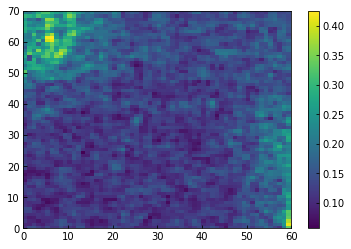

In [69]:
plt.pcolormesh(data_std)
plt.colorbar()

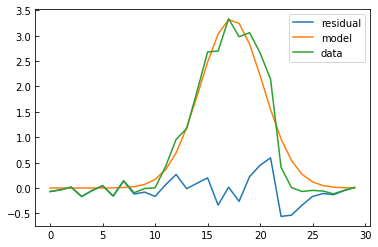

<Quantity 12.13582997>

In [70]:
x, y = 25, 30
plt.plot(resid[25:55, y, x], label='residual')
plt.plot(model[25:55, y, x], label='model')
plt.plot(ls_data[25:55, y, x], label='data')
plt.legend()
plt.show()

np.sum(resid[30:55, y, x]**2)/data_std[y, x]**2/(len(resid[30:55, y, x])-16)

In [198]:
def calc_chi2(data, model, gaussians, ch_start = 25, ch_end = 55):
    """
    Pass in a PPV cube of the original data as well as the reconstructed ROHSA cube 
    and return a map of the reduced chi2 statistic
    """
    chi2_map = np.zeros([data.shape[1], data.shape[2]])
    
    resid = model - data
    params = (ch_end-ch_start) - 3*gaussians
    stds = np.std(data[:20, :, :], axis=0)
    
    for x in range(0, data.shape[2]):
        for y in range(0, data.shape[1]):
    
            chi2_map[y][x] = np.sum(resid[ch_start:ch_end, y, x]**2) / stds[y, x]**2 / (params)
        
    return chi2_map

In [209]:
chi2_map = calc_chi2(ls_data, model, n_gauss)

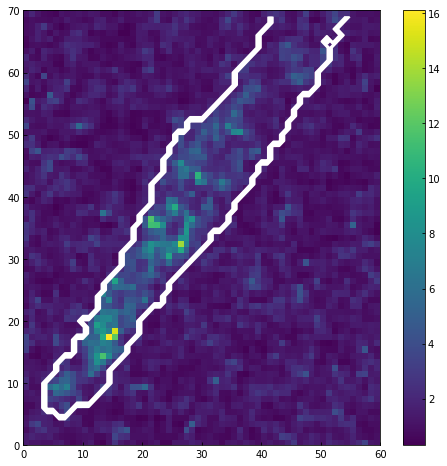

In [219]:
amp_maskt = amplitude[0] > 10*data_std
amp_gt = np.empty(amp_maskt.shape)
amp_gt.fill(np.nan)
amp_gt[amp_maskt == True] = 1

plt.figure(figsize=(8, 8))
plt.pcolormesh(chi2_map)
plt.colorbar()
plt.contour(amp_maskt, colors='white', linewidths=2)
plt.savefig('chi2_singlegaussian.png')

#np.nanmean(np.ravel((amp_gt*chi2_map)))

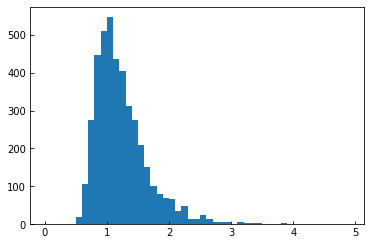

In [19]:
plt.hist(np.ravel(chi2_map), bins=np.arange(0, 5, 0.1))
plt.show()

In [114]:
np.mean(np.ravel(chi2_map))

1.2411292654146

In [22]:
np.savetxt('chi2_map_ngauss_3.txt', chi2_map, header='2D map for the a 3 gaussian fit')

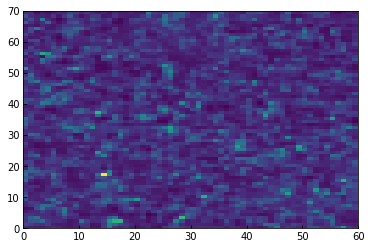

In [24]:
plt.pcolormesh(np.loadtxt('chi2_test.txt'))

In [95]:
for i in range(1, 11):    
    
    filename = "HC2_HC5N_CubeEx.dat" #@param
    fileout = "HC2_HC5N_CubeEx_gauss_run_0.dat" #@param
    filename_noise = ''
    n_gauss = i        #@param {type:"slider", min:1, max:12, step:1}                                                                                                                                                                                                                             
    lambda_amp = 100 #@param {type:"slider", min:0, max:1000, step:1}
    lambda_mu = 100       #@param {type:"slider", min:0, max:1000, step:1}
    lambda_sig = 100      #@param {type:"slider", min:0, max:1000, step:1}
    lambda_var_amp = 0.                                                                                                                                                                                                                                                           
    lambda_var_mu = 0.                                                                                                                                                                                                                                                        
    lambda_var_sig = 0.   #@param {type:"slider", min:0, max:10000, step:1}                                                                                                                                                                                                                                                            
    amp_fact_init = 0.66  # times max amplitude of additional Gaussian                                                                                                                                                                                                                                                          
    sig_init = 4.         # dispersion of additional Gaussian                                                                                                                                                                                                                                                                   
    init_option = 'mean'  # init ROHSA with the mean or the std spectrum                                                                                                                                                                                                                                                      
    maxiter_init = 15000  # max iteration for L-BFGS-B alogorithm init mean                                                                                                                                                                                                                                        
    maxiter = 400         #@param {type:"slider", min:1, max:800, step:1}                                                                                                                                                                                                                                                         
    m = 10                # number of corrections used in the limited memory matrix                                                                                                                                                                                                                               
    noise = ".false."     # if false - STD map computed by ROHSA with lstd and ustd                                                                                                                                                                                                           
    regul = ".true."      # if true - activate regulation                                                                                                                                                                                                                                                                 
    descent = ".true."    #@param [".true.", ".false."]                                                                                                                                                                                                                       
    lstd = 1              #@param {type:"slider", min:1, max:400, step:1}                                                                                                                                                                                                                
    ustd = 20             #@param {type:"slider", min:1, max:400, step:1}                                                                                                                                                                                                                 
    iprint = -1           #@param ["-1", "0", "1"]                                                                                                                                                                                                                                                                                      
    iprint_init = -1      # print option init                                              
    save_grid = ".false." #@param [".true.", ".false."] 

    core = ROHSA(ls_data, hdr = ls_head)            
    core.cube2dat(filename=filename)
    core.gen_parameters(filename=filename, 
                        fileout=fileout,  
                        n_gauss=n_gauss,
                        lambda_amp=lambda_amp,
                        lambda_mu=lambda_mu,
                        lambda_sig=lambda_sig,
                        lambda_var_sig=lambda_var_sig,
                        maxiter=maxiter,
                        descent=descent,
                        lstd=lstd,
                        ustd=ustd,
                        iprint=iprint,
                        save_grid=save_grid)


    ! nohup ./ROHSA/src/ROHSA parameters.txt

    gaussian = core.read_gaussian("HC2_HC5N_CubeEx_gauss_run_0.dat")
    params = core.physical_gaussian(gaussian)
    print("dim cube = " + str(gaussian.shape))

    model = core.return_result_cube(gaussian=gaussian)

    reconstructed_cube = core.return_result_cube(gaussian)

    amplitude = params[0::3]
    position = params[1::3]
    dispersion = -1*params[2::3]

    integral = amplitude * dispersion

    chi2_map = calc_chi2(ls_data, model, n_gauss)

    np.savetxt('chi2_map_ngauss_'+str(n_gauss)+'_redo.txt', chi2_map, header='2D map for the a '+str(n_gauss)+' gaussian fit')

Generate HC2_HC5N_CubeEx.dat file readable by fortran
Generate parameters.txt file
appending output to nohup.out
Opening data file
dim cube = (3, 70, 60)
Generate HC2_HC5N_CubeEx.dat file readable by fortran
Generate parameters.txt file
appending output to nohup.out
Opening data file
dim cube = (6, 70, 60)
Generate HC2_HC5N_CubeEx.dat file readable by fortran
Generate parameters.txt file
appending output to nohup.out
Opening data file
dim cube = (9, 70, 60)
Generate HC2_HC5N_CubeEx.dat file readable by fortran
Generate parameters.txt file
appending output to nohup.out
Opening data file
dim cube = (12, 70, 60)
Generate HC2_HC5N_CubeEx.dat file readable by fortran
Generate parameters.txt file
appending output to nohup.out
Opening data file
dim cube = (15, 70, 60)
Generate HC2_HC5N_CubeEx.dat file readable by fortran
Generate parameters.txt file
appending output to nohup.out
Opening data file
dim cube = (18, 70, 60)
Generate HC2_HC5N_CubeEx.dat file readable by fortran
Generate parameters

/Users/simonsmith/anaconda3/lib/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


In [224]:
AICc = []
for i in range(1, 10):
    chi2 = np.nanmean(amp_gt*np.loadtxt('chi2_data/chi2_map_ngauss_'+str(i)+'_redo.txt'))
    print(chi2)
    

3.242210279314491
2.2477492268819512
1.5934524771940668
1.6414801099596308
2.1286807848962566
2.7285612455600146
3.768695447985511
8.246684205155686
16.433562207786935


In [29]:
chi2_g2 = np.loadtxt('chi2_data/chi2_map_ngauss_'+str(2)+'_redo.txt')
chi2_g3 = np.loadtxt('chi2_data/chi2_map_ngauss_'+str(3)+'_redo.txt')
chi2_g4 = np.loadtxt('chi2_data/chi2_map_ngauss_'+str(4)+'_redo.txt')
chi2_g5 = np.loadtxt('chi2_data/chi2_map_ngauss_'+str(5)+'_redo.txt')
    

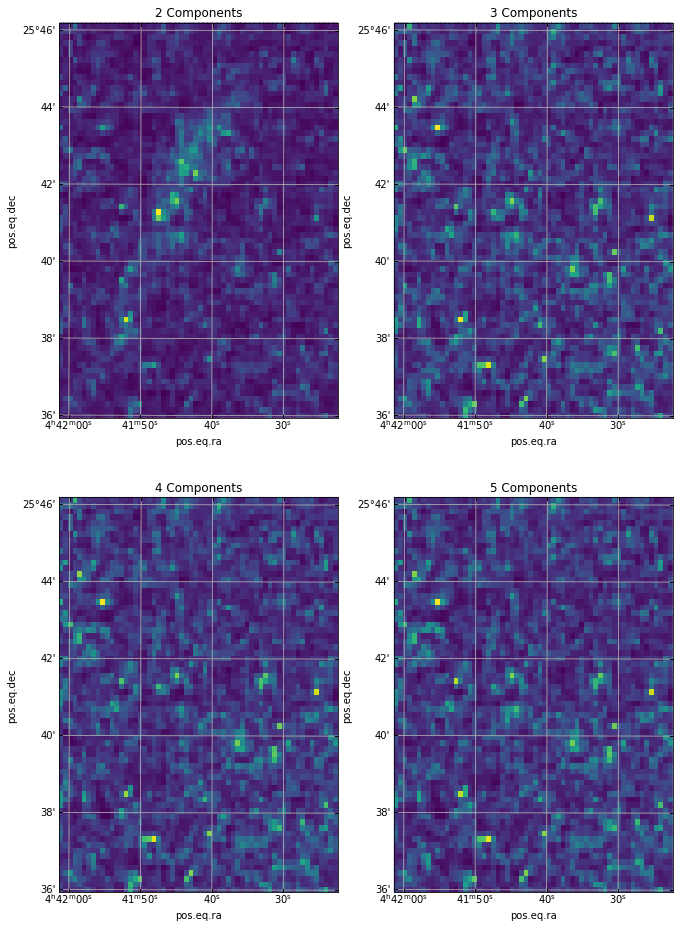

In [30]:
fig = plt.figure(figsize=(11, 16))

ax1 = fig.add_subplot(221, projection=ls_tmc1.wcs)
ax1.pcolormesh(chi2_g2)
ax1.set_title('2 Components')

ax2 = fig.add_subplot(222, projection=ls_tmc1.wcs)
ax2.pcolormesh(chi2_g3)
ax2.set_title('3 Components')

ax3 = fig.add_subplot(223, projection=ls_tmc1.wcs)
ax3.pcolormesh(chi2_g4)
ax3.set_title('4 Components')

ax4 = fig.add_subplot(224, projection=ls_tmc1.wcs)
ax4.pcolormesh(chi2_g5)
ax4.set_title('5 Components')

plt.show()

In [36]:
np.nanmean(amp_gt*chi2_g3), np.nanmean(amp_gt*chi2_g4)

(1.5382116622230089, 1.596812233310066)

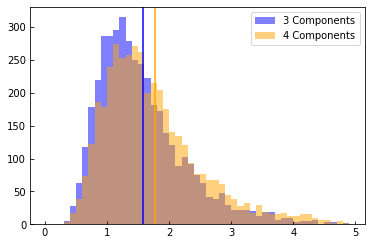

In [32]:
plt.hist(np.ravel(chi2_g3), bins=np.arange(0, 5, 0.1), alpha=0.5, color='blue', label='3 Components')
plt.hist(np.ravel(chi2_g4), bins=np.arange(0, 5, 0.1), alpha=0.5, color='orange', label='4 Components')
plt.axvline(np.mean(chi2_g3), color='blue')
plt.axvline(np.mean(chi2_g4), color='orange')
plt.legend()
plt.show()


# SAVING THE FITS FILE, DO NOT RUN AGAIN

In [10]:
def sort_high(integral, position, dispersion):
    """
    Simple sorter, from high to low, for ROHSA fits
    """
    new_int = []
    new_pos = []
    new_dis = []
    integral = [integral[0], integral[1], integral[2]]
    position = [position[0], position[1], position[2]]
    dispersion = [dispersion[0], dispersion[1], dispersion[2]]
    
    while len(integral) != 0:
        highest = 0
        for i in range(len(integral)):
            if np.mean(integral[i]) > np.mean(integral[highest]):
                highest = i
        new_int.append(integral[highest])
        new_pos.append(position[highest])
        new_dis.append(dispersion[highest])

        integral.pop(highest)
        position.pop(highest)
        dispersion.pop(highest)
        
    return np.array(new_int), np.array(new_pos), np.array(new_dis)

In [11]:
new_int, new_pos, new_dis = sort_high(integral, position, dispersion)

In [30]:
tmc1_hdu = fits.PrimaryHDU(np.array(ls_data))

In [31]:
int1_hdu = fits.ImageHDU(new_int[0])
int2_hdu = fits.ImageHDU(new_int[1])
int3_hdu = fits.ImageHDU(new_int[2])

vel1_hdu = fits.ImageHDU(new_pos[0])
vel2_hdu = fits.ImageHDU(new_pos[1])
vel3_hdu = fits.ImageHDU(new_pos[2])

dis1_hdu = fits.ImageHDU(new_dis[0])
dis2_hdu = fits.ImageHDU(new_dis[1])
dis3_hdu = fits.ImageHDU(new_dis[2])

In [32]:
tmc1_hdul = fits.HDUList([tmc1_hdu, 
                          int1_hdu, int2_hdu, int3_hdu, 
                          vel1_hdu, vel2_hdu, vel3_hdu, 
                          dis1_hdu, dis2_hdu, dis3_hdu])

In [ ]:
CDELT1  =  -0.0024440485689343 / [deg] Coordinate increment at reference point  
CDELT2  =   0.0024440485689343
CRVAL1  =      70.142553931966 / [deg] Coordinate value at reference point      
CRVAL2  =      25.919390064115

In [69]:
tmc1_hdul[2].header['CRPIX1'] = 135
tmc1_hdul[2].header['CRPIX2'] = 132
tmc1_hdul[2].header['CDELT1'] = -0.0024440485689343
tmc1_hdul[2].header['CDELT2'] = 0.0024440485689343
tmc1_hdul[2].header['CRVAL1'] = 70.142553931966
tmc1_hdul[2].header['CRVAL2'] = 25.919390064115

In [82]:
tmc1_hdul[1].header

WCSAXES =                    2 / Number of coordinate axes                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   60                                                  
NAXIS2  =                   70                                                  
CRPIX1  =                135.0 / Pixel coordinate of reference point            
CRPIX2  =                132.0 / Pixel coordinate of reference point            
CDELT1  =  -0.0024440485689343 / [deg] Coordinate increment at reference point  
CDELT2  =   0.0024440485689343 / [deg] Coordinate increment at reference point  
CUNIT1  = 'deg'                / Units of coordinate increment and value        
CUNIT2  = 'deg'                / Units of coordinate increment and value        
CTYPE1  = 'RA---TAN'           / Right ascension, gnomonic projection           
CTYPE2  = 'DEC--TAN'        

In [ ]:
ls_tmc1.wcs.to_header()

In [79]:
tmc1_hdul.writeto('ls.fits', overwrite=True)

VerifyError: 
Verification reported errors:
HDU 1:
    'XTENSION' card does not exist.
    'PCOUNT' card does not exist.
    'GCOUNT' card does not exist.
    'PCOUNT' card does not exist.
Note: astropy.io.fits uses zero-based indexing.


In [ ]:
def sort_low(arr):
    """
    Simple sorter, from low to high
    """
    new_arr = []
    
    
    while len(arr) != 0:
        lowest = 0
        for i in range(len(arr)):
            if np.mean(arr[i]) < np.mean(arr[lowest]):
                lowest = i
        new_arr.append(arr[lowest])

        arr.pop(lowest)
        
    return np.array(new_arr)

# FITS SAVING DONE

In [86]:
data_std = np.mean(np.std(ls_data[:20, :, :], axis=0))
10*data_std

<Quantity 1.43647584>

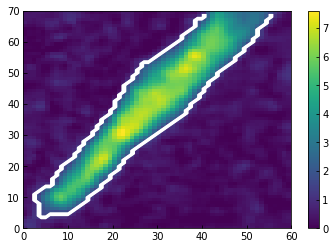

In [87]:
amp_tot = amplitude[0]+amplitude[1]+amplitude[2]

amp_maskt = amp_tot > 10*data_std
amp_gt = np.empty(amp_maskt.shape)
amp_gt.fill(np.nan)
amp_gt[amp_maskt == True] = 1

plt.pcolormesh(amp_tot)
plt.colorbar()
plt.contour(amp_maskt, colors='white')

In [25]:
#TMC-1 Lower Section Masks

ls_mask1 = integral[0] > 0.03
ls_g1 = np.empty(ls_mask1.shape)
ls_g1.fill(np.nan)
ls_g1[ls_mask1 == True] = 1

ls_mask2 = integral[1] > 0.08
ls_g2 = np.empty(ls_mask2.shape)
ls_g2.fill(np.nan)
ls_g2[ls_mask2 == True] = 1

ls_mask3 = integral[2] > 0.05 
ls_g3 = np.empty(ls_mask3.shape)
ls_g3.fill(np.nan)
ls_g3[ls_mask3 == True] = 1

total_int = integral[0]+integral[1]+integral[2]
ls_maskt = total_int > np.std(ls_data[:20, :, :])
ls_gt = np.empty(ls_maskt.shape)
ls_gt.fill(np.nan)
ls_gt[ls_maskt == True] = 1

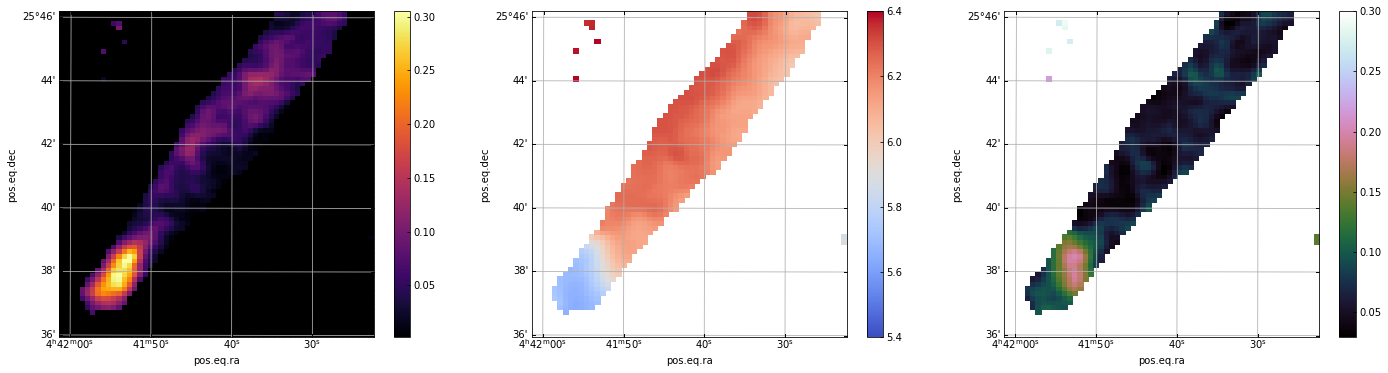

In [26]:
fig = plt.figure(figsize=[24, 6], constrained_layout=False)


ax1 = fig.add_subplot(131, projection=ls_tmc1.wcs)
im1 = ax1.pcolormesh(ls_gt*integral[0], cmap="inferno")
cbar1 = plt.colorbar(im1)


ax2 = fig.add_subplot(132, projection=ls_tmc1.wcs)
im2 = ax2.pcolormesh(ls_gt*position[0], cmap="coolwarm", vmin=5.4, vmax=6.4)
#plt.yticks([])
cbar2 = plt.colorbar(im2)

ax3 = fig.add_subplot(133, projection=ls_tmc1.wcs)
im3 = ax3.pcolormesh(ls_gt*dispersion[0], cmap="cubehelix", vmax=0.3)
#plt.yticks([])
cbar3 = plt.colorbar(im3)

plt.show()

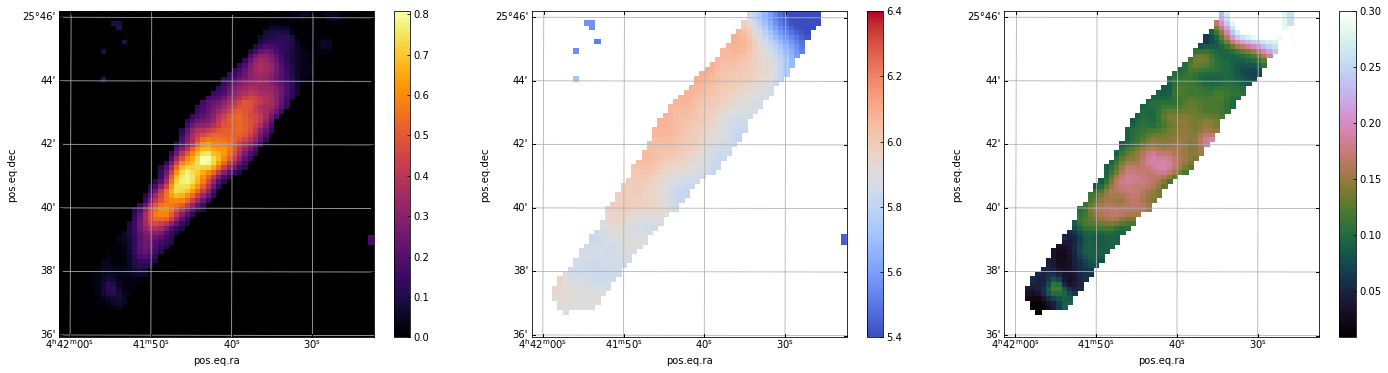

In [27]:
fig = plt.figure(figsize=[24, 6], constrained_layout=False)


ax1 = fig.add_subplot(131, projection=ls_tmc1.wcs)
im1 = ax1.pcolormesh(ls_gt*integral[1], cmap="inferno")
cbar1 = plt.colorbar(im1)


ax2 = fig.add_subplot(132, projection=ls_tmc1.wcs)
im2 = ax2.pcolormesh(ls_gt*position[1], cmap="coolwarm", vmin=5.4, vmax=6.4)
#plt.yticks([])
cbar2 = plt.colorbar(im2)

ax3 = fig.add_subplot(133, projection=ls_tmc1.wcs)
im3 = ax3.pcolormesh(ls_gt*dispersion[1], cmap="cubehelix", vmax=0.3)
#plt.yticks([])
cbar3 = plt.colorbar(im3)

plt.show()

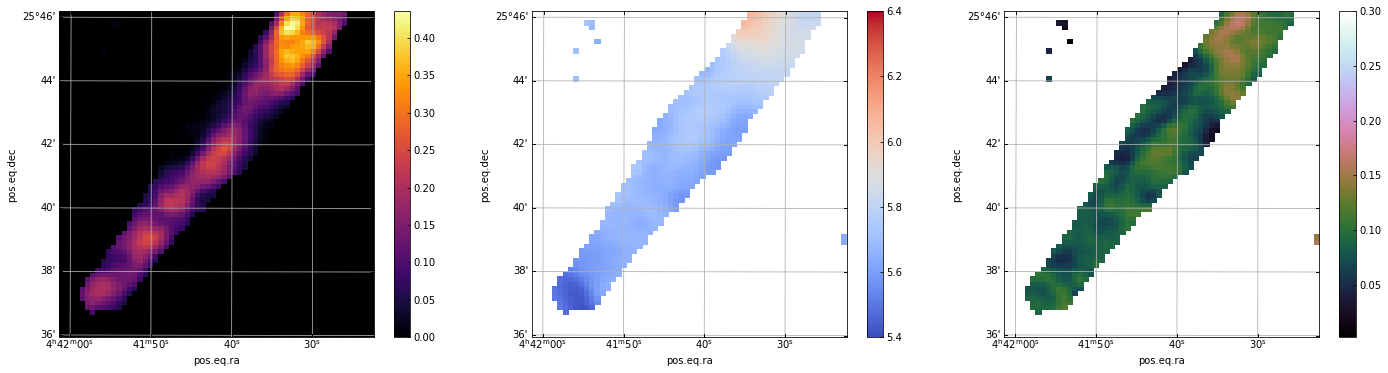

In [28]:
fig = plt.figure(figsize=[24, 6], constrained_layout=False)


ax1 = fig.add_subplot(131, projection=ls_tmc1.wcs)
im1 = ax1.pcolormesh(ls_gt*integral[2], cmap="inferno")
cbar1 = plt.colorbar(im1)


ax2 = fig.add_subplot(132, projection=ls_tmc1.wcs)
im2 = ax2.pcolormesh(ls_gt*position[2], cmap="coolwarm", vmin=5.4, vmax=6.4)
#plt.yticks([])
cbar2 = plt.colorbar(im2)

ax3 = fig.add_subplot(133, projection=ls_tmc1.wcs)
im3 = ax3.pcolormesh(ls_gt*dispersion[2], cmap="cubehelix", vmax=0.3)
#plt.yticks([])
cbar3 = plt.colorbar(im3)

plt.show()

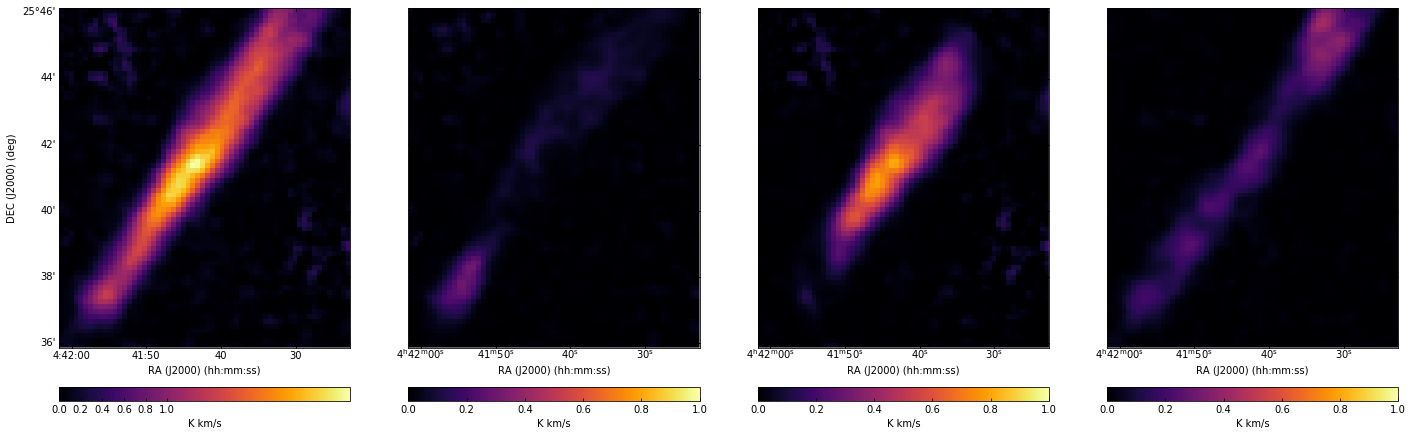

In [19]:
fig = plt.figure(figsize=(24, 9), constrained_layout=False)
ax1 = fig.add_subplot(141, projection=ls_tmc1.wcs)
im = ax1.imshow((integral[0]+integral[1]+integral[2])*np.sqrt(2*np.pi),cmap='inferno', vmin=0)
ra = ax1.coords[0]
ra.set_major_formatter('hh:mm:ss')
ra.set_separator(':')
cbar = plt.colorbar(im,pad=0.08,orientation='horizontal', ticks=[0, 0.2, 0.4, 0.6, 0.8, 1])
cbar.set_label('K km/s')
ax1.set_xlabel('RA (J2000) (hh:mm:ss)')
ax1.set_ylabel('DEC (J2000) (deg)')

ax2 = fig.add_subplot(142, projection=ls_tmc1.wcs)
im2 = ax2.imshow(integral[0],cmap='inferno', vmin=0, vmax=1)
de = ax2.coords[1]
de.set_ticklabel_visible(False)
cbar = plt.colorbar(im2,pad=0.08,orientation='horizontal', ticks=[0, 0.2, 0.4, 0.6, 0.8, 1])
cbar.set_label('K km/s')


ax2.set_xlabel('RA (J2000) (hh:mm:ss)')
ax2.set_ylabel('DEC (J2000) (deg)')

ax3 = fig.add_subplot(143, projection=ls_tmc1.wcs)
im3 = ax3.imshow(integral[1],cmap='inferno', vmin=0, vmax=1)
de = ax3.coords[1]
de.set_ticklabel_visible(False)
cbar = plt.colorbar(im3,pad=0.08,orientation='horizontal', ticks=[0, 0.2, 0.4, 0.6, 0.8, 1])
cbar.set_label('K km/s')


ax3.set_xlabel('RA (J2000) (hh:mm:ss)')
ax3.set_ylabel('DEC (J2000) (deg)')

ax4 = fig.add_subplot(144, projection=ls_tmc1.wcs)
im4 = ax4.imshow(integral[2],cmap='inferno', vmin=0, vmax=1)
de = ax4.coords[1]
de.set_ticklabel_visible(False)
cbar = plt.colorbar(im4,pad=0.08,orientation='horizontal', ticks=[0, 0.2, 0.4, 0.6, 0.8, 1])
cbar.set_label('K km/s')


ax4.set_xlabel('RA (J2000) (hh:mm:ss)')
ax4.set_ylabel('DEC (J2000) (deg)')

What Questions am I really trying to answer?
Remember, the HC5N just traces the H2

For instance: 
how do the kinematics of a filament affect star formation rates?
how do the kinematics of subfilaments affect the stability of a region?
what does HC5N actually trace? is that gas moving fast? slow?

In [54]:
#TMC-1 Lower Section Masks 4 gaussians

ls_mask1 = integral[0] > 0.03
ls_g1 = np.empty(ls_mask1.shape)
ls_g1.fill(np.nan)
ls_g1[ls_mask1 == True] = 1

ls_mask2 = integral[1] > 0.08
ls_g2 = np.empty(ls_mask2.shape)
ls_g2.fill(np.nan)
ls_g2[ls_mask2 == True] = 1

ls_mask3 = integral[2] > 0.05 
ls_g3 = np.empty(ls_mask3.shape)
ls_g3.fill(np.nan)
ls_g3[ls_mask3 == True] = 1

ls_mask4 = integral[3] > 0.05 
ls_g4 = np.empty(ls_mask4.shape)
ls_g4.fill(np.nan)
ls_g4[ls_mask4 == True] = 1

total_int = integral[0]+integral[1]+integral[2]+integral[3]
ls_maskt = total_int > 0.16
ls_gt = np.empty(ls_maskt.shape)
ls_gt.fill(np.nan)
ls_gt[ls_maskt == True] = 1

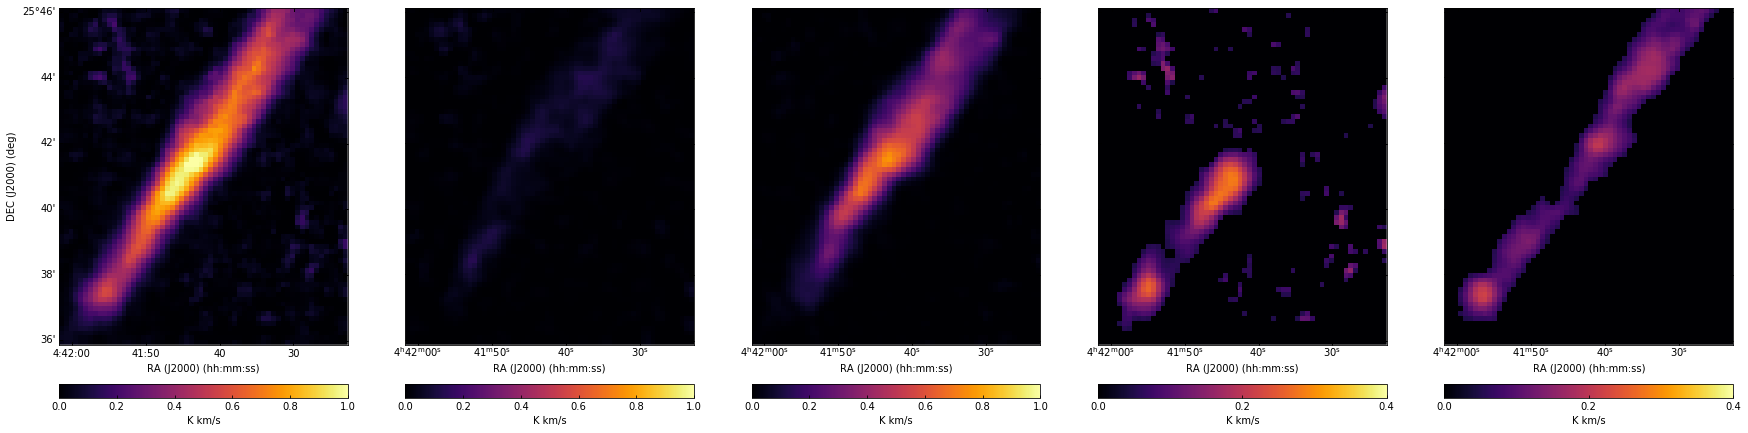

In [56]:
fig = plt.figure(figsize=(30, 9), constrained_layout=False)
ax1 = fig.add_subplot(151, projection=ls_tmc1.wcs)
im = ax1.imshow(integral[0]+integral[1]+integral[2]+integral[3],cmap='inferno', vmin=0, vmax=1)
ra = ax1.coords[0]
ra.set_major_formatter('hh:mm:ss')
ra.set_separator(':')
cbar = plt.colorbar(im,pad=0.08,orientation='horizontal', ticks=[0, 0.2, 0.4, 0.6, 0.8, 1])
cbar.set_label('K km/s')
ax1.set_xlabel('RA (J2000) (hh:mm:ss)')
ax1.set_ylabel('DEC (J2000) (deg)')

ax2 = fig.add_subplot(152, projection=ls_tmc1.wcs)
im2 = ax2.imshow(integral[0],cmap='inferno', vmin=0, vmax=1)
de = ax2.coords[1]
de.set_ticklabel_visible(False)
cbar = plt.colorbar(im2,pad=0.08,orientation='horizontal', ticks=[0, 0.2, 0.4, 0.6, 0.8, 1])
cbar.set_label('K km/s')


ax2.set_xlabel('RA (J2000) (hh:mm:ss)')
ax2.set_ylabel('DEC (J2000) (deg)')

ax3 = fig.add_subplot(153, projection=ls_tmc1.wcs)
im3 = ax3.imshow(integral[1],cmap='inferno', vmin=0, vmax=1)
de = ax3.coords[1]
de.set_ticklabel_visible(False)
cbar = plt.colorbar(im3,pad=0.08,orientation='horizontal', ticks=[0, 0.2, 0.4, 0.6, 0.8, 1])
cbar.set_label('K km/s')


ax3.set_xlabel('RA (J2000) (hh:mm:ss)')
ax3.set_ylabel('DEC (J2000) (deg)')

ax4 = fig.add_subplot(154, projection=ls_tmc1.wcs)
im4 = ax4.imshow(ls_mask3*integral[2],cmap='inferno', vmin=0, vmax=0.4)
de = ax4.coords[1]
de.set_ticklabel_visible(False)
cbar = plt.colorbar(im4,pad=0.08,orientation='horizontal', ticks=[0, 0.2, 0.4, 0.6, 0.8, 1])
cbar.set_label('K km/s')


ax4.set_xlabel('RA (J2000) (hh:mm:ss)')
ax4.set_ylabel('DEC (J2000) (deg)')

ax5 = fig.add_subplot(155, projection=ls_tmc1.wcs)
im5 = ax5.imshow(ls_mask4*integral[3],cmap='inferno', vmin=0, vmax=0.4)
de = ax5.coords[1]
de.set_ticklabel_visible(False)
cbar = plt.colorbar(im5,pad=0.08,orientation='horizontal', ticks=[0, 0.2, 0.4, 0.6, 0.8, 1])
cbar.set_label('K km/s')


ax5.set_xlabel('RA (J2000) (hh:mm:ss)')
ax5.set_ylabel('DEC (J2000) (deg)')

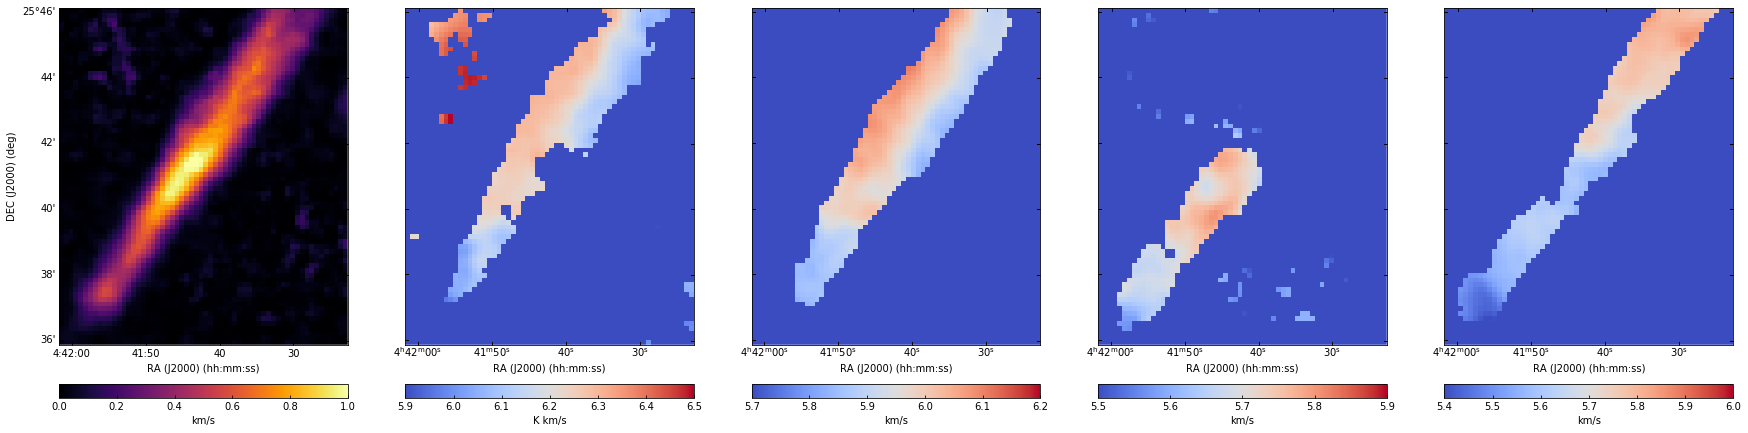

In [80]:
fig = plt.figure(figsize=(30, 9), constrained_layout=False)
ax1 = fig.add_subplot(151, projection=ls_tmc1.wcs)
im = ax1.imshow(integral[0]+integral[1]+integral[2]+integral[3],cmap='inferno', vmin=0, vmax=1)
ra = ax1.coords[0]
ra.set_major_formatter('hh:mm:ss')
ra.set_separator(':')
cbar = plt.colorbar(im,pad=0.08,orientation='horizontal', ticks=[0, 0.2, 0.4, 0.6, 0.8, 1])
cbar.set_label('km/s')
ax1.set_xlabel('RA (J2000) (hh:mm:ss)')
ax1.set_ylabel('DEC (J2000) (deg)')

ax2 = fig.add_subplot(152, projection=ls_tmc1.wcs)
im2 = ax2.imshow(ls_mask1*position[0],cmap='coolwarm', vmin=5.9, vmax=6.5)
de = ax2.coords[1]
de.set_ticklabel_visible(False)
cbar = plt.colorbar(im2,pad=0.08,orientation='horizontal', ticks=[5.9, 6.0, 6.1, 6.2, 6.3, 6.4, 6.5])
cbar.set_label('K km/s')


ax2.set_xlabel('RA (J2000) (hh:mm:ss)')
ax2.set_ylabel('DEC (J2000) (deg)')

ax3 = fig.add_subplot(153, projection=ls_tmc1.wcs)
im3 = ax3.imshow(ls_mask2*position[1],cmap='coolwarm', vmin=5.7, vmax=6.2)
de = ax3.coords[1]
de.set_ticklabel_visible(False)
cbar = plt.colorbar(im3,pad=0.08,orientation='horizontal', ticks=[5.7, 5.8, 5.9, 6.0, 6.1, 6.2])
cbar.set_label('km/s')


ax3.set_xlabel('RA (J2000) (hh:mm:ss)')
ax3.set_ylabel('DEC (J2000) (deg)')

ax4 = fig.add_subplot(154, projection=ls_tmc1.wcs)
im4 = ax4.imshow(ls_mask3*position[2],cmap='coolwarm', vmin=5.5, vmax=5.9)
de = ax4.coords[1]
de.set_ticklabel_visible(False)
cbar = plt.colorbar(im4,pad=0.08,orientation='horizontal', ticks=[5.5, 5.6, 5.7, 5.8, 5.9])
cbar.set_label('km/s')


ax4.set_xlabel('RA (J2000) (hh:mm:ss)')
ax4.set_ylabel('DEC (J2000) (deg)')

ax5 = fig.add_subplot(155, projection=ls_tmc1.wcs)
im5 = ax5.imshow(ls_mask4*position[3],cmap='coolwarm', vmin=5.4, vmax=6)
de = ax5.coords[1]
de.set_ticklabel_visible(False)
cbar = plt.colorbar(im5,pad=0.08,orientation='horizontal', ticks=[5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6.0])
cbar.set_label('km/s')


ax5.set_xlabel('RA (J2000) (hh:mm:ss)')
ax5.set_ylabel('DEC (J2000) (deg)')

len(20)/4 = 5

0, 5      = 5i - 5, 5i
5, 10
10, 15

In [113]:
for i in range(2, 21):
    print(i)

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


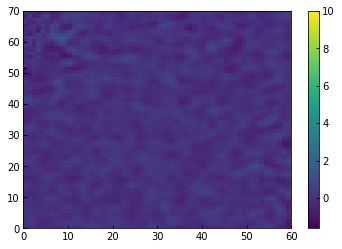

16


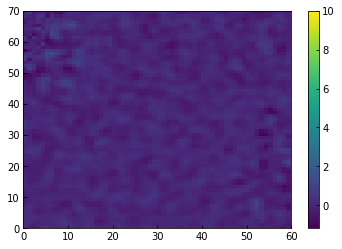

17


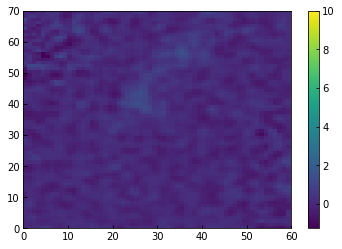

18


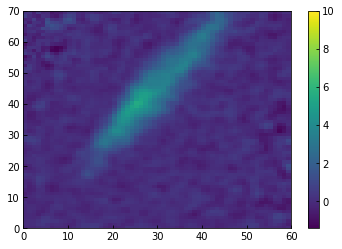

19


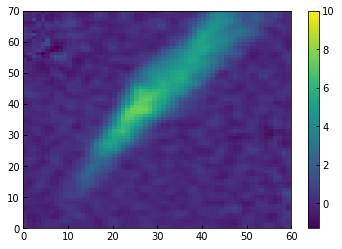

20


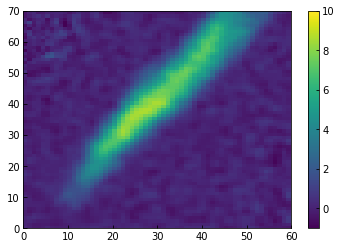

21


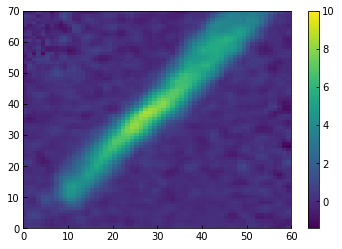

22


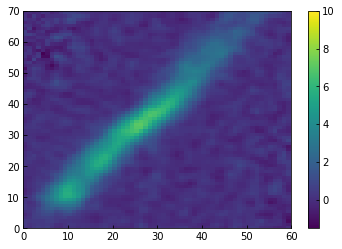

23


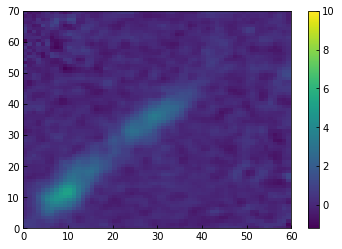

24


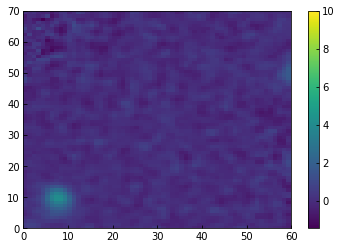

25


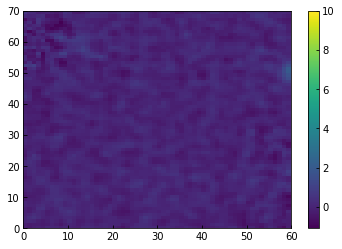

26


In [25]:

for i in range(16, 27):
    plt.pcolormesh(np.sum(ls_data[int(2*i - 2):int(2*i)], axis=0), vmax=10)
    plt.colorbar()
    plt.show()
    print(i)

## Moment Maps

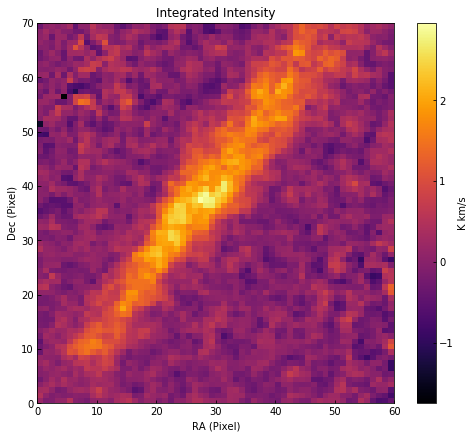

In [72]:
v_lsr = rad_v.to(u.km/u.s)[::-1]
dv = v_lsr[1]-v_lsr[0]

plt.figure(figsize=(8, 7))
plt.pcolormesh(np.sum(ls_data, 0)*dv, cmap='inferno')
cbar = plt.colorbar()

cbar.set_label('K km/s')
plt.title('Integrated Intensity')
plt.ylabel('Dec (Pixel)')
plt.xlabel('RA (Pixel)')

plt.show()


In [66]:
v_mean = np.zeros([70, 60])
for i in range(0, 60):
    for j in range(0, 70):
        v_mean[j, i] = np.sum(v_lsr*ls_data[:, j, i])/np.sum(ls_data[:, j, i])*u.s/u.km    

In [67]:
j, i = 40, 30
np.sum(v_lsr*ls_data[:, j, i])/np.sum(ls_data[:, j, i])

<Quantity 6.07995221 km / s>

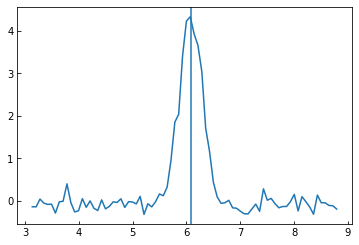

In [30]:
plt.plot(v_lsr, ls_data[:, 40, 30])
plt.axvline(v_mean)

In [57]:
v_mean = np.zeros([70, 60])
v_lsr[0], v_lsr[-1]

(<Quantity 3.13664949 m / s>, <Quantity 8.79176675 m / s>)

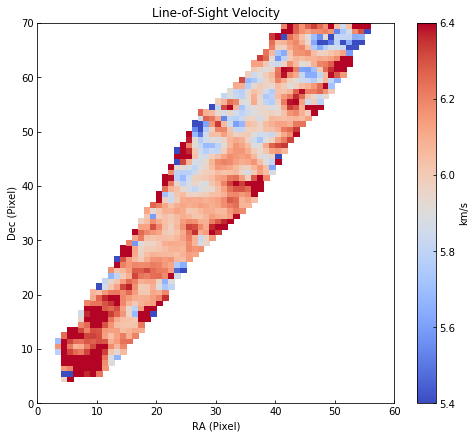

In [88]:

plt.figure(figsize=(8, 7))
plt.pcolormesh(amp_gt*v_mean, cmap='coolwarm', vmin=5.4, vmax=6.4)
cbar = plt.colorbar()

cbar.set_label('km/s')
plt.title('Line-of-Sight Velocity')
plt.ylabel('Dec (Pixel)')
plt.xlabel('RA (Pixel)')

plt.show()

In [68]:
v_mean[40, 30]

6.079952207856805